In [89]:
import pandas as pd
from matplotlib import pyplot as plt
from somda_project.helpers import lineplot 
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from datetime import datetime,timedelta
import json
from scipy.stats import pearsonr
from somda_project.data import wikicode_translations

In [90]:
df = pd.read_csv("data/merged_election_pages.csv", parse_dates=['timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'], format="mixed")
df.index = df["timestamp"]
df.fillna(df.mode().iloc[0], inplace=True)

In [91]:
f = open('./data/eu_elections.json')
election_data = json.load(f)

In [92]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format="mixed")
df = df.groupby(['wikicode', pd.Grouper(key='timestamp', freq='D')]).sum().reset_index(level='wikicode')
df[df["wikicode"] == "cs"].head()

,wikicode,hourly_views
timestamp,,
2009-05-21,cs,54.0
2009-05-22,cs,41.0
2009-05-23,cs,25.0
2009-05-24,cs,60.0
2009-05-25,cs,73.0


In [93]:
df.rename(columns={'hourly_views': 'views'}, inplace=True)
scaler = MinMaxScaler()
df['views_norm'] = df.groupby([df.index.year, 'wikicode'])['views'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
pivot_df = df.pivot_table(index='timestamp', columns='wikicode', values='views_norm')
pivot_df_abs = df.pivot_table(index='timestamp', columns='wikicode', values='views')
pivot_df_abs = pivot_df_abs.rename(columns=wikicode_translations)
pivot_df = pivot_df.rename(columns=wikicode_translations)
for column in pivot_df.columns:
    pivot_df[column] = scaler.fit_transform(pivot_df[column].values.reshape(-1, 1))


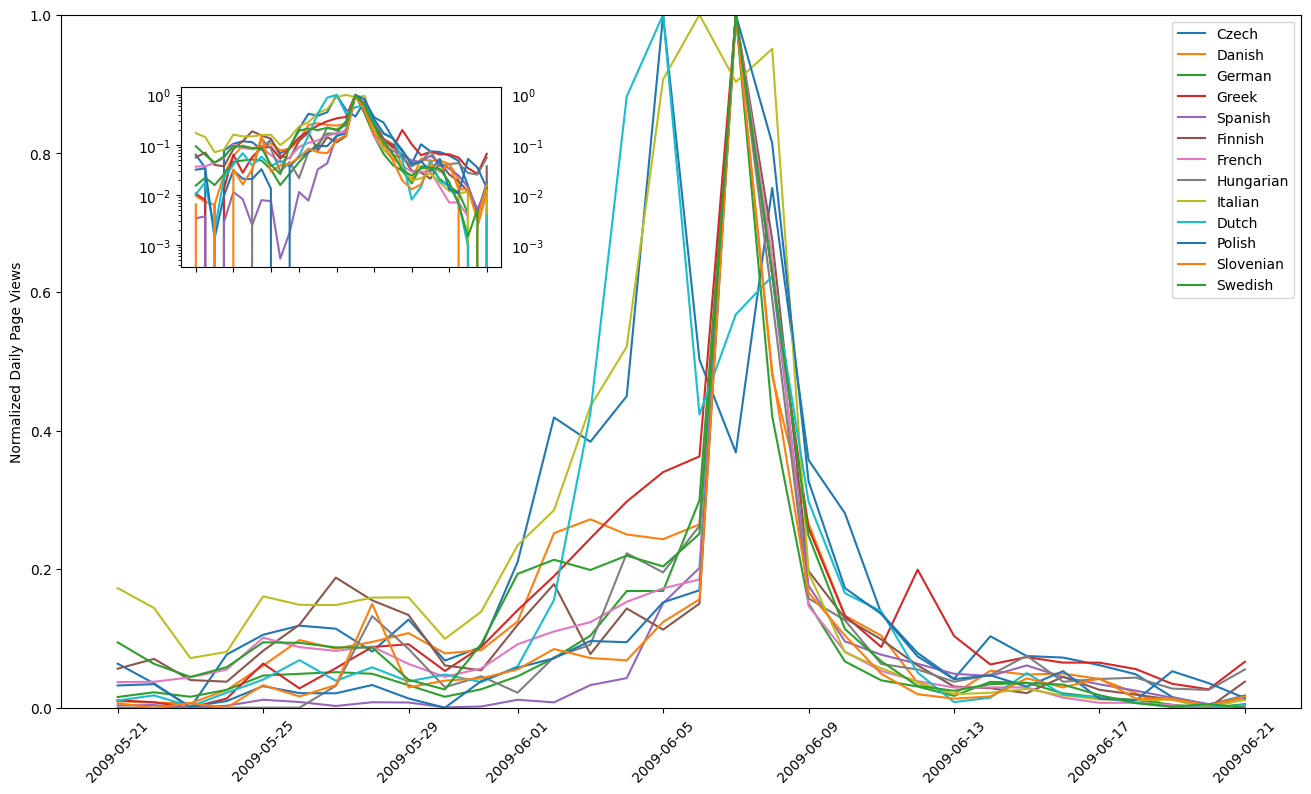

In [94]:
fig, ax1 = plt.subplots(figsize=(16, 9))
lineplot(pivot_df[pivot_df.index.year == 2009], ax1, show_inset=True, fig=fig)
plt.savefig('./report/fig/lineplot_2009.png')

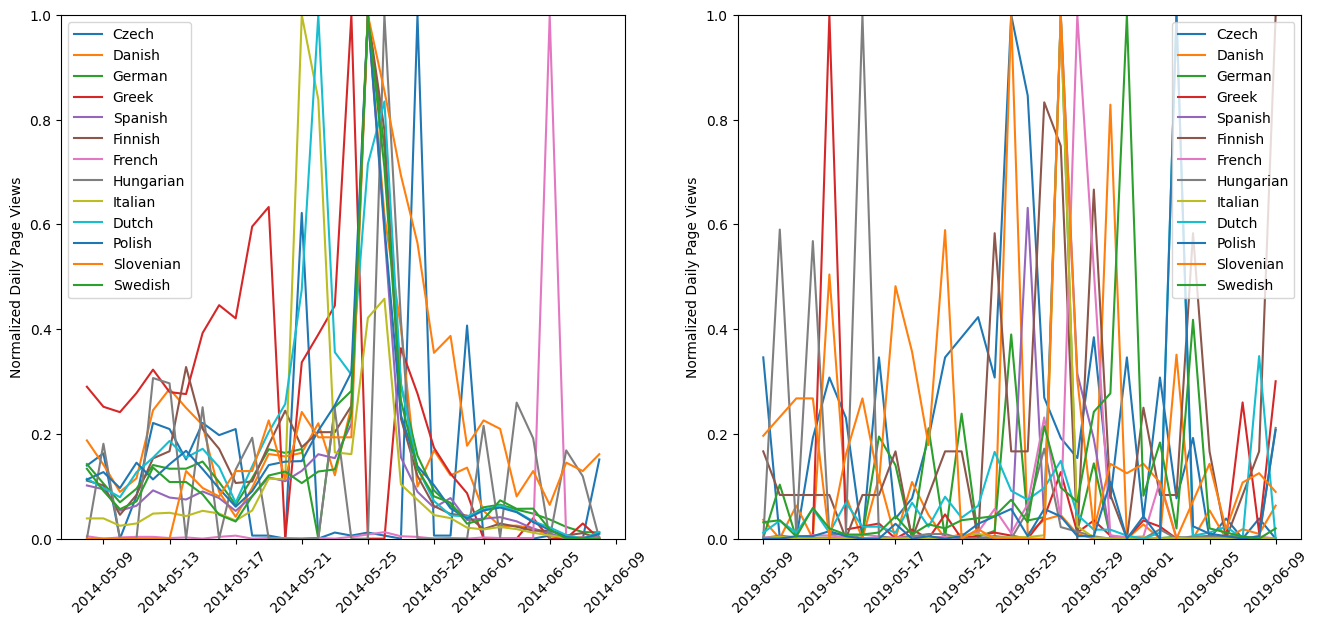

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6.8))
lineplot(pivot_df[pivot_df.index.year == 2014], ax1)
lineplot(pivot_df[pivot_df.index.year == 2019], ax2)
plt.savefig('./report/fig/lineplot_2014_2019.png')
plt.show()

In [96]:
nan_counts = pivot_df.groupby(pivot_df.index.year).apply(lambda x: x.isna().sum())
print(nan_counts)
zero_counts = pivot_df.groupby(pivot_df.index.year).apply(lambda x: x.eq(0).sum())
print("\n Zero counts: \n", zero_counts)

wikicode   Czech  Danish  German  Greek  Spanish  Finnish  French  Hungarian  \
timestamp                                                                      
2009           0       0       0      0        0        0       0          0   
2014           0       0       0      0        0        0       0          0   
2019           0       0       0      0        0        0       0          0   

wikicode   Italian  Dutch  Polish  Slovenian  Swedish  
timestamp                                              
2009             0      0       0          0        0  
2014             0      0       0          0        0  
2019             0      0       0          0        0  

 Zero counts: 
 wikicode   Czech  Danish  German  Greek  Spanish  Finnish  French  Hungarian  \
timestamp                                                                      
2009           1       1       1      1        1        1       1          6   
2014          10       1       1      8        1        1     

<Axes: xlabel='timestamp'>

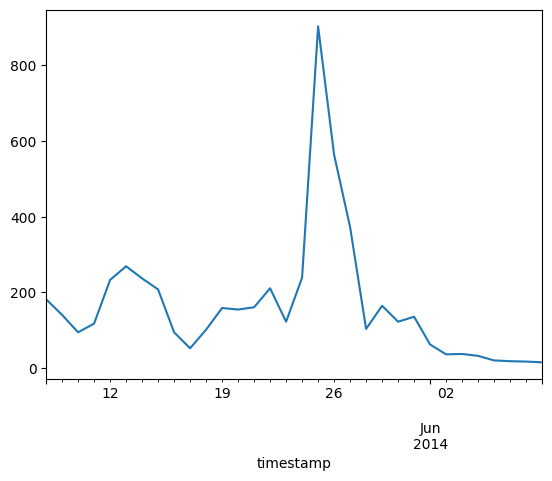

In [97]:
# visualize outlier

pivot_df_abs["Danish"][pivot_df_abs.index.year == 2014].plot()

In [98]:
pivot_df_abs

wikicode,Czech,Danish,German,Greek,Spanish,Finnish,French,Hungarian,Italian,Dutch,Polish,Slovenian,Swedish
timestamp,,,,,,,,,,,,,
2009-05-21,54.0,58.0,3324.0,23.0,64.0,29.0,1884.0,0.0,2671.0,125.0,549.0,3.0,311.0
2009-05-22,41.0,53.0,4294.0,21.0,66.0,35.0,1903.0,0.0,2266.0,148.0,563.0,1.0,227.0
2009-05-23,25.0,51.0,3378.0,15.0,45.0,22.0,2169.0,0.0,1248.0,99.0,326.0,3.0,176.0
2009-05-24,60.0,93.0,4794.0,25.0,61.0,21.0,2629.0,0.0,1374.0,160.0,386.0,1.0,214.0
2009-05-25,73.0,170.0,7706.0,63.0,109.0,40.0,4523.0,0.0,2503.0,218.0,542.0,11.0,311.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-05,1.0,7.0,255.0,2.0,2.0,3.0,12.0,2.0,5.0,3.0,3.0,9.0,7.0
2019-06-06,2.0,1.0,35.0,1.0,3.0,1.0,3.0,2.0,8.0,5.0,2.0,2.0,5.0
2019-06-07,1.0,3.0,103.0,46.0,15.0,2.0,6.0,2.0,26.0,1.0,1.0,7.0,3.0


In [99]:
# Build up phase volume: sum of page views 7 days before election date
country_lst = []
turnout_lst = []
page_views_lst = []

for country in election_data.keys():
    res_turnout = (election_data[country]["2019"]["turnout"] - election_data[country]["2014"]["turnout"]) / election_data[country]["2014"]["turnout"]
    election_data[country]["relative_change_turnout"] = res_turnout
    turnout_lst.append(res_turnout)

    sum_dct = {}
    for year in ["2009", "2014"]:
        election_date = datetime.strptime(election_data[country][year]["election_date"], "%Y-%m-%d")
        country_df = df[df["wikicode"] == election_data[country]["wikicode"]]

        start_date = election_date - timedelta(days=7)
        end_date = election_date
        
        sum_views = country_df[(country_df.index >= start_date) & (country_df.index <= end_date)]["views"].sum()
        
        sum_dct[year] = sum_views

    res_page_views = (sum_dct["2014"] - sum_dct["2009"]) / sum_dct["2009"]
    election_data[country]["relative_change_page_views"] = res_page_views
    page_views_lst.append(res_page_views)
    country_lst.append(country)

/tmp/ipykernel_154125/1882494304.py:23: RuntimeWarning: invalid value encountered in scalar divide
  res_page_views = (sum_dct["2014"] - sum_dct["2009"]) / sum_dct["2009"]


In [100]:
change_df = pd.DataFrame({"country": country_lst, "rel_change_turnout": turnout_lst, "rel_change_views": page_views_lst})
change_df.head()

,country,rel_change_turnout,rel_change_views
0,CZ,0.578022,NaN
1,DK,0.173295,NaN
2,DE,0.276091,NaN
3,EL,-0.021344,NaN
4,FI,0.043478,NaN


In [101]:
# exclude PL and ES
# change_df = change_df[change_df["country"] != "PL"]
# change_df = change_df[change_df["country"] != "CZ"]
# change_df = change_df[change_df["country"] != "ES"]

In [102]:
correlation, p_value = pearsonr(change_df["rel_change_views"], change_df["rel_change_turnout"])
print("Correlation coefficient (r):", correlation)
print("P-value:", p_value)

ValueError: array must not contain infs or NaNs

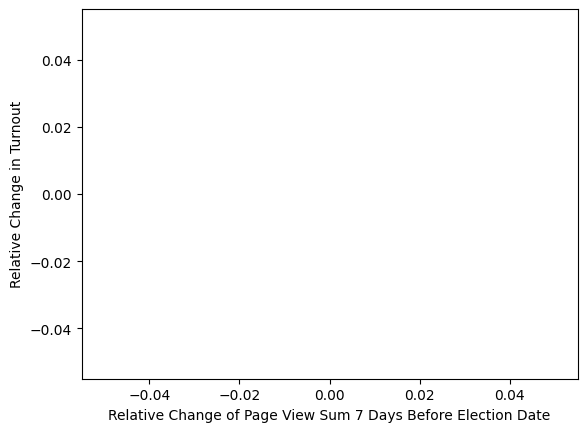

In [ ]:

plt.scatter(change_df["rel_change_views"], change_df["rel_change_turnout"])

for i in range(len(change_df)):
    x = change_df["rel_change_views"].iloc[i]
    y = change_df["rel_change_turnout"].iloc[i]
    country = change_df["country"].iloc[i]
    plt.annotate(country, xy=(x, y), xytext=(4, 5), textcoords="offset points")

# Create a line plot for the correlation line
# x_line = np.linspace(min(change_df["rel_change_views"]), max(change_df["rel_change_views"]), 100)
# y_line = correlation * x_line
# plt.plot(x_line, y_line, color='red', linestyle='--', label='Correlation line')

plt.xlabel("Relative Change of Page View Sum 7 Days Before Election Date")
plt.ylabel("Relative Change in Turnout")

plt.show()


In [ ]:
election_data["PL"]["relative_change_page_views"]

nan

In [ ]:
election_data["CZ"]["relative_change_page_views"]

nan

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


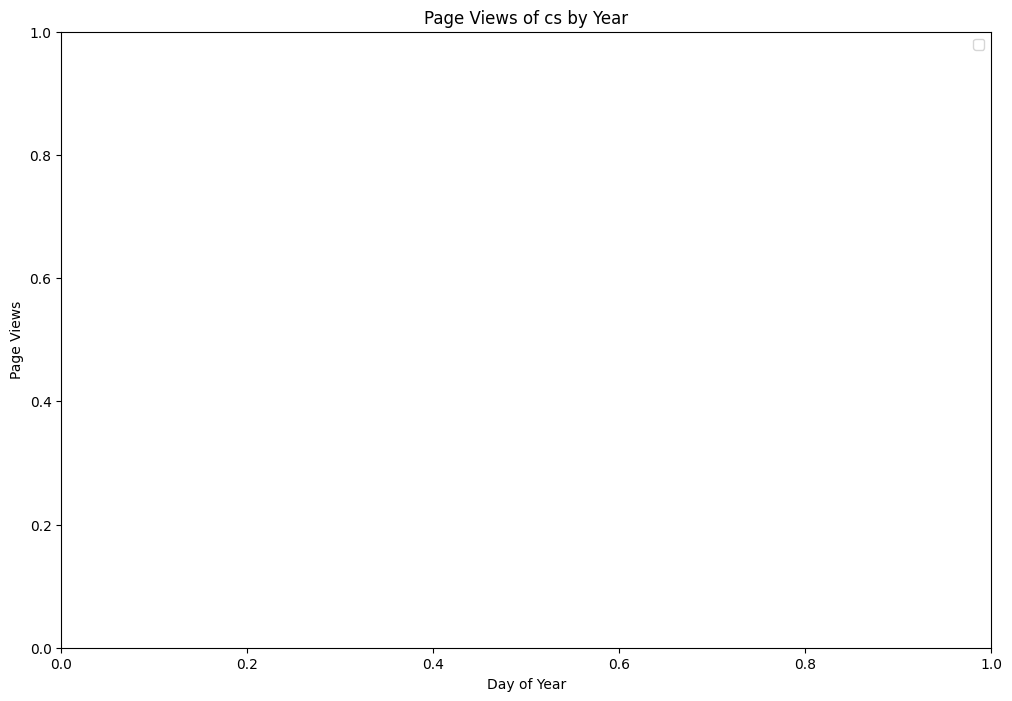

In [ ]:
import matplotlib.pyplot as plt
c = "cs"
# Filter the DataFrame for Poland and Czech Republic
df_single = df[df['wikicode'] == f'{c}.wikipedia'].copy()

# Convert the date to day of year using .loc indexer
df_single.loc[:, 'day_of_year'] = df_single.index.dayofyear

# Group the DataFrame by year
grouped = df_single.groupby(df_single.index.year)

# Create the plot
plt.figure(figsize=(12, 8))

# Iterate over each group and plot
for year, group in grouped:
    plt.plot(group['day_of_year'], group['views'], label=str(year))

# Add labels and title
plt.xlabel('Day of Year')
plt.ylabel('Page Views')
plt.title(f'Page Views of {c} by Year')

# Add a legend
plt.legend()

# Show the plot
plt.show()
